# Script 1: Ensemble 
### This script shows how to caluclate and plot ensemble means. 

## Content:
### Section 1 includes the packages, PMIP model lists and some basic stuff used to find the right directory and filenames. 
### Section2 provides the functions and options for calculating ensemble means
### Section 3 provides the options for potting and shows some examples

# Section 1: Importing packages and defining general information
This section has three parts. The first one lists and imports the packages that are required in calculating and plotting. The second one provides the full lists of models in PMIP4 and PMIP3. The third one defines a set of functions to find the filenames of the files that have the variable in the experiment.

### No changes should be made in this section, unless you have some necessary modifications. 


In [1]:
'''Import packages for loading data, analysing, and plotting'''
# This cell imports the necessary packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe

import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import os
import matplotlib.colors as colors
import netCDF4 as nc
import tarfile




In [2]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-1-1-LR',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['BCC-CSM1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']
               
               
#expand out the provided data if there isn't already something there
if not os.path.exists('../data/piControl'):
   tar = tarfile.open("data/PMIP4-PMIP3_allfields.tar.gz")
   tar.extractall(path='../data/')
               

## This part define the functions to find files fitting variable and experiment requirements.

In [3]:
#No change needs here
#This cell defines the functions to find variables, models and experiments


#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data/"
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members = [] #create an empty list
    with os.scandir(datadir) as entries:
        for entry in entries:
            this_file=xr.open_dataset(entry,decode_times=False)
            if variable_name in list(this_file.keys()):
                ensemble_members.append(datadir+"/"+entry.name)
            this_file.close()
    return ensemble_members

#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


# Section 2: Calculating functions
This section defines two functions that can return ensemble (mean) and ensemble (mean) change by choosing appropriate input variables, respectively. Results are regridded to 1x1 deg resolution (i.e. 180x360 grids). Detailed explanation and guidelines are given below.
### If you don't want to create a netCDF file to save the outputs, remove the lines noted by "#remove this line if you don't want to save the resluts" in functions

The functions have five inputs:

pmip_v: Define the PMIP generation as "PMIP4" or "PMIP3" 

experiment_name: Define the name of the target experiment, e.g. "midHolocene". *If you want to use calendar adjusted variables, you need to add "-cal-adj" after the experimental name, e.g. "midHolocene-cal-adj".*

variable_name: Define the name of the target variable, e.g. "tas_spatialmean_ann"

savedirct: Define the directory to save output files. #remove this input if you don't want to save the results into a netCDF file.

choice: Define the returned variable choices by "model", "mean" and "both". 
"model" will save and return the model list and a directory including all absolute values of (or changes in) the target variable in the target experimental simulations from each individual model; Output model_list, DATA.

"mean" will save and return the ensemble mean and ensemble standard deviation of the absolute values of (or the changes in) the target variable; Output model_list, ave, std

"both" will save and return the outputs from both "model" and "mean"; Output model_list, ave, std, DATA

Outputs:
model_list: Full list of models included in the ensemble
ave: Ensemble mean of the variable (change)
std: Ensemble standard deviation of the variable (change)
DATA: A directoy including the variable (change) simulated by each model, named same as the model name.

## Function 1: calculation_ensemble
calculation_ensemble_change calculates and returns regrided ensemble mean (or individual models), absolute values of the rarget variable in the target experiment. Outputs will be saved in as a netCDF file named 'PMIP_generation'_'experiment_name'_'variable_name'_emsemble_mean.nc" in your chosen directory. 



In [4]:
def createfile(pmip_v,experiment_name,variable_name):
    savefile = '%s_%s_%s_emsemble_mean.nc' %(pmip_v,experiment_name,variable_name) 
    lonS = np.arange(-179.5, 180., 1.0) 
    latS = np.arange(-89.5, 90., 1.0) 
    d = Dataset(savefile,'w',format='NETCDF4') 
    d.createDimension('lon',360)  
    d.createDimension('lat',180)  
    d.createVariable("lon",'f',("lon"))  
    d.createVariable("lat",'f',("lat"))  
    d.variables['lat'][:] = latS     
    d.variables['lon'][:] = lonS   
    d.close()
    return savefile

In [5]:
def calculation_ensemble(pmip_v,experiment_name,variable_name,choice): 
    modelfile = '%s_%s_%s_emsemble_mean_models.csv' %(pmip_v,experiment_name,variable_name)
    # Create a netCDF file to save the outputs
    #savefile = createfile(pmip_v,experiment_name,variable_name) #remove this line if you don't want to save the resluts
    #d = Dataset(savefile,'a') #remove this line if you don't want to save the resluts
    model_list = []
    DATA = {}
    data=[]
    var_dict = ensemble_members_dict(variable_name,experiment_name)
    grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    for gcm in var_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)              
                expt_file = xr.open_dataset(var_dict.get(gcm),decode_times=False)
                var = expt_file[variable_name]
                this_regridder = xe.Regridder(expt_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                var_1x1 = this_regridder(var)               
                data.append(var_1x1)
                if choice == 'model' or 'both': #remove this line if you don't want to save the resluts
                    DATA[gcm] = var_1x1
                    #d.createVariable(gcm,'f',("lat",'lon')) #remove this line if you don't want to save the resluts
                    #d.variables[gcm][:] = var_1x1   #remove this line if you don't want to save the resluts                  
    pd.DataFrame(model_list).to_csv(modelfile)
    if choice == 'mean' or 'both':
        data1 = np.array(data)
        ave = var_1x1*0
        ave.values = np.average(data1,axis=0)
        std = var_1x1*0
        std.values = np.std(data1,axis=0)
        #d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
        #d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['std'][:] = std #remove this line if you don't want to save the resluts
    #d.close()    #remove this line if you don't want to save the resluts
    if choice == 'mean':
        return model_list,ave,std
    if choice == 'model':
        return model_list,DATA
    if choice == 'both':
        return model_list,ave,std,DATA



## Function 2: calculation_ensemble_change
calculation_ensemble_change calculates and returns regrided ensemble mean of absolute changes in the target variable in the target experiment. Outputs will be saved in as a netCDF file named "<PMIP_generation>_<experiment_name>_<variable_name>_emsemble_mean.nc" in your chosen directory. 




In [6]:
def calculation_ensemble_change(pmip_v,experiment_name,variable_name,choice):
    modelfile = '%s_%s_%s_emsemble_mean_change_models.csv' %(pmip_v,experiment_name,variable_name)
    # Create a netCDF file to save the outputs
    #savefile = createfile(pmip_v,experiment_name,variable_name) #remove this line if you don't want to save the resluts
    #d = Dataset(savefile,'a') #remove this line if you don't want to save the resluts
    model_list = []
    DATA = {}
    data = []
    A_dict = ensemble_members_dict(variable_name,experiment_name)
    B_dict = ensemble_members_dict(variable_name,'piControl')
    grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
                if gcm in pmip[pmip_v]:
                    model_list.append(gcm)              
                    expt_a_file = xr.open_dataset(A_dict.get(gcm),decode_times=False)
                    expt_a = expt_a_file[variable_name]
                    expt_b_file = xr.open_dataset(B_dict.get(gcm),decode_times=False)
                    expt_b = expt_b_file[variable_name]
                    diff = expt_a - expt_b
                    this_regridder = xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                    diff_1x1 = this_regridder(diff)               
                    data.append(diff_1x1)
                    if choice == 'model' or 'both':
                        DATA[gcm] = diff_1x1
                        #d.createVariable(gcm,'f',("lat",'lon')) #remove this line if you don't want to save the resluts
                        #d.variables[gcm][:] = diff_1x1   #remove this line if you don't want to save the resluts                  
    pd.DataFrame(model_list).to_csv(modelfile)
    if choice == 'mean' or 'both':
        data1 = np.array(data)
        ave = diff_1x1*0
        ave.values = np.average(data1,axis=0)
        std = diff_1x1*0
        std.values = np.std(data1,axis=0)
        #d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
        #d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
        #d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
       # d.variables['std'][:] = std  #remove this line if you don't want to save the resluts
   # d.close()    
    if choice == 'mean':
        return model_list,ave,std
    if choice == 'model':
        return model_list,DATA
    if choice == 'both':
        return model_list,ave,std,DATA




## Calculating the ensemble (mean)

Choose the appropriate inputs. Available inputs are listed afterwards

In [7]:
pmip_v = "PMIP4" #"PMIP4" or "PMIP3"

In [8]:
experiment_name = "piControl" 
#       Period              Experiment name            Name of experiment with calendar adjustment applied
#     mid-Holocene           midHolocene                  midHolocene-cal-adj
#     Last Interglacial       lig127k                     lig127k-cal-adj

In [9]:
variable_name = "pr_spatialmean_jja" #e.g. the spatial mean of annual mean surface air temperature (deg C)
# Full list of available variable names can be found in variablenamelist.csv


# The spatial mean variables are named as <variable>_spatialmean_<season>
# commonly used variables:
# tas: surface air temperature (deg C)
# pr: precipitation rate (mm/day)
# psl: sea level pressure (hPa)

# Examples:
# tas_spatialmean_ann: the spatial mean of annual mean surface air temperature (deg C)
# tas_spatialmean_djf: the spatial mean of Dec-Jan-Feb mean surface air temperature (deg C)
# tas_spatialmean_jja: the spatial mean of Jun-Jul-Aug mean surface air temperature (deg C)
# pr_spatialmean_ann: the spatial mean of annual mean precipitation rate (mm/day)
# pr_spatialmean_djf: the spatial mean of Dec-Jan-Feb precipitation rate (mm/day)
# pr_spatialmean_jja: the spatial mean of Jun-Jul-Aug precipitation rate (mm/day)


In [10]:
choice = "both" # "mean", "model" or "both"

# model: save and return the model list and a directory including all absolute values of (or changes in) the rarget variable in the target experimental simulations from each individual model;
# model_list,DATA = calculation_ensemble_change(pmip_v,experiment_name,variable_name,"model")


# mean: save and return the ensemble mean and ensemble standard deviation of the absolute values of (or the changes in) the rarget variable;
# model_list,ave,std = calculation_ensemble_change(pmip_v,experiment_name,variable_name,"mean")


# both: save and return the outputs from both "model" and "mean".
# model_list,ave,std,DATA = calculation_ensemble_change(pmip_v,experiment_name,variable_name,"both")

In [11]:
# e.g.
model_list,ave,std,DATA = calculation_ensemble(pmip_v,experiment_name,variable_name,choice)
model_list1,ave1,std1,DATA1 = calculation_ensemble('PMIP3',experiment_name,variable_name,choice)
#model_list,DATA = calculation_ensemble_change(pmip_v,experiment_name,variable_name,choice)
#model_list,ave= calculation_ensemble(pmip_v,experiment_name,variable_name,choice="model")

/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amm_pr_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amm_tas_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amo_pr_regression_lowpass_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'amo_pr_regression_mon' has multiple fill values {-1073741800.0, 1e+20}, decoding all

In [30]:
model_list1

['BCC-CSM1-1',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'CSIRO-Mk3L-1-2',
 'EC-EARTH-2-2',
 'FGOALS-g2',
 'FGOALS-s2',
 'GISS-E2-R',
 'HadGEM2-CC',
 'HadGEM2-ES',
 'IPSL-CM5A-LR',
 'MIROC-ESM',
 'MPI-ESM-P',
 'MRI-CGCM3']

In [13]:
def pr_obs():
    obs_file=xr.open_dataset('C20-Reanalysis_1981-2010.cvdp_data.1871-2012.nc',decode_times=False)
    domain=obs_file['pr_spatialmean_jja']
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                             'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    this_regridder=xe.Regridder(obs_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
    obs_domain=this_regridder(domain)
    domain_r=np.array(obs_domain)
    ax=pd.DataFrame(domain_r)
    DO=np.array(ax.fillna(3000))
    return DO

In [14]:
obs=xr.open_dataset('C20-Reanalysis_1981-2010.cvdp_data.1871-2012.nc',decode_times=False)
obs_pr=obs['pr_spatialmean_jja']

In [15]:
observe=pr_obs()

In [16]:
diff=ave-observe

In [17]:
diff_pmip3=ave-ave1

In [18]:
diff_model=[]
for model in model_list:
    difference=DATA[model]-observe
    diff_model.append(difference)
    

    
    

In [19]:
obs_ave=np.mean(observe[119:139,279:329])
obs_ave

4.374977

In [20]:
percentage=diff/obs_ave

In [21]:
np.mean(percentage[119:139,279:329])

<xarray.DataArray ()>
array(-0.02564691, dtype=float32)

In [22]:
per=[]
for i in np.arange(0,15,1):
    individual=diff_model[i]
    data_eas1=np.sum(individual[109:139,279:299])
    data_eas2=np.sum(individual[130:139,299:319])
    model_ave=(data_eas1+data_eas2)/(780)
    per.append(model_ave/obs_ave)
    print(model_list[i],':     {:.2f}%'.format(float(model_ave/obs_ave*100)))

ACCESS-ESM1-5 :     0.23%
CESM2 :     5.96%
CNRM-CM6-1 :     -24.30%
EC-Earth3-LR :     -34.06%
FGOALS-f3-L :     -52.13%
FGOALS-g3 :     -45.02%
GISS-E2-1-G :     -37.95%
HadGEM3-GC31-LL :     -8.23%
INM-CM4-8 :     14.37%
IPSL-CM6A-LR :     -27.79%
MIROC-ES2L :     11.40%
MPI-ESM1-2-LR :     -21.47%
MRI-ESM2-0 :     -22.38%
NESM3 :     -9.32%
NorESM1-F :     -9.14%


In [23]:
np.mean(per)

-0.17320432371433617

# Section 3: Plotting

This section gives some defined plotting setups that were used in Brierley et al. (2020) and Otto-Bliesner et al. (2021)

## Rainfall 
This section shows how to create a similar figures looking at annual mean precipitation changes. 
*Only the data needed to create this particular version (midHolocene-piControl) comes bundled with the repository (due to data constraints). If you want to look at other experiments, please look at the final cell of this notebook.*

In [24]:
# Precipitaion
#abs precipitation rate
def axplot1_pr(ax,modeldata,title):
    cmap1=plt.get_cmap('GnBu')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    bounds1 =[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7,8,9,10,12,14,16,40]
    norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
    ax.set_title(title,fontsize=15)
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(modeldata.lon,modeldata.lat,modeldata,levels=bounds1,transform=transform,cmap=cmap1,norm=norm1)
    cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in [ax]],location='bottom',pad=0.05,fraction=0.05)
    cb1=plt.colorbar(fig, cax=cax1, **kw1,extend='max')
    cb1label='Precipitation rate (mm/day)'
    cb1.set_label(cb1label,fontsize=15)
    cb1.ax.tick_params(labelsize=12)
    return fig


# PMIP4 anomalies
def axplot2_pr(ax,modeldata,title):
    cmap1=plt.get_cmap('BrBG')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    bounds1 = [-13,-2,-1.5,-1,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,1,1.5,2,13]
    #bounds1 =[-100,-3,-2.4,-2,-1.6,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.6,2,2.4,3,100]
    #bounds1=np.arange(-3,3.3,0.3)
    norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
    ax.set_title(title,fontsize=15)
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(modeldata.lon,modeldata.lat,modeldata,levels=bounds1,transform=transform,cmap=cmap1,norm=norm1) 
    cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in [ax]],location='bottom',pad=0.05,fraction=0.05)
    cb1=plt.colorbar(fig, cax=cax1, **kw1,extend='both')
    cb1label=' precipitation differeence (mm/day)'
    cb1.set_label(cb1label,fontsize=15)
    cb1.ax.tick_params(labelsize=12)
    return fig



# std
def axplot3_pr(ax,modeldata,title):
    cmap1=plt.get_cmap('YlGn')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    bounds1 =[0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,6]
    norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
    ax.set_title(title,fontsize=15)
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(modeldata.lon,modeldata.lat,modeldata,levels=bounds1,transform=transform,cmap=cmap1,norm=norm1) 
    cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in [ax]],location='bottom',pad=0.05,fraction=0.05)
    cb1=plt.colorbar(fig, cax=cax1, **kw1,extend='max')
    cb1label='Ensemble standard deviation (mm/day)' 
    cb1.set_label(cb1label,fontsize=15)
    cb1.ax.tick_params(labelsize=12)
    return fig



In [25]:
# Create a figure showing ensemble mean
def meanplotting_pr(var,data):
    plt.figure()
    ax1=plt.axes(projection=ccrs.Robinson())
    axplot2_pr(ax1,data,var) # change function here
    plt.savefig('%s_ensemble_mean.png'%var)
    #plt.savefig('%s_ensemble_mean.png'%var)
def regional_plot_pr(var,data):
    plt.figure(figsize=(12,6)  , dpi=100)
    entral_lon=-10
    central_lat = 45
    extent = [100, 150, 20, 50]
    ax = plt.axes(projection=ccrs.Orthographic(125, 35))
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    axplot1_pr(ax,data,var)
    plt.savefig('%s_ensemble_mean.png'%var)
def regional_plot_pr_diff(var,data):
    plt.figure(figsize=(12,6)  , dpi=100)
    entral_lon=-10
    central_lat = 45
    extent = [100, 150, 20, 50]
    ax = plt.axes(projection=ccrs.Orthographic(125, 35))
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    axplot2_pr(ax,data,var)
    plt.savefig('%s_ensemble_mean.png'%var)

/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/conda/envs/pmip_p2fvar_analyzer/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/conda/envs/pmip_p2fvar_ana

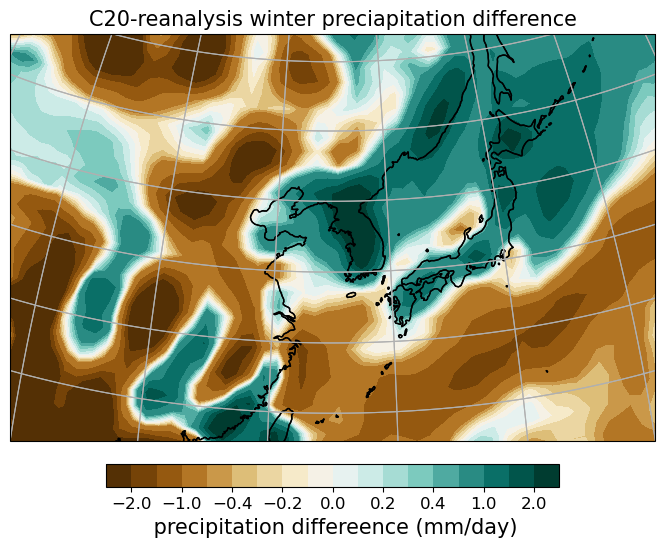

In [26]:
regional_plot_pr_diff('C20-reanalysis winter preciapitation difference',diff)


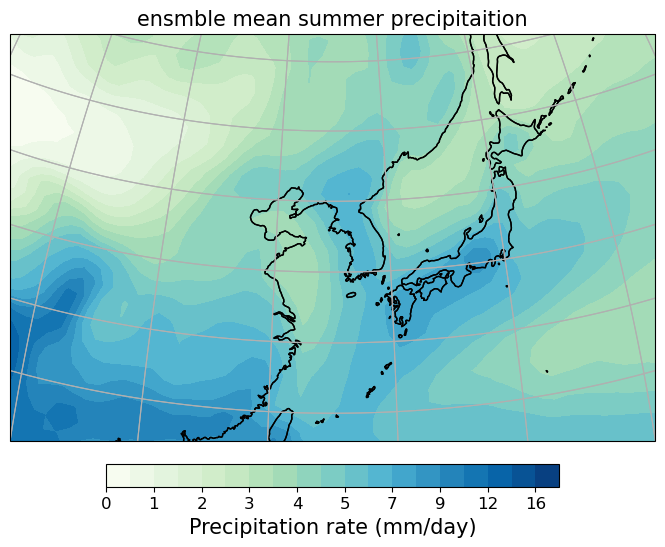

In [27]:
regional_plot_pr('ensmble mean summer precipitaition',ave)

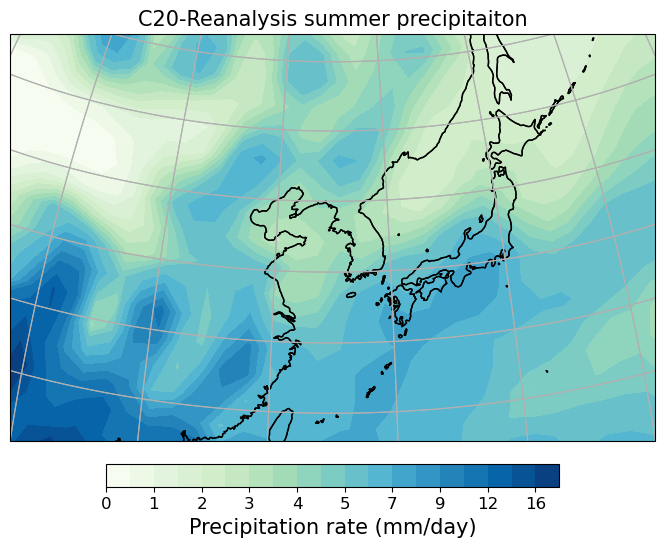

In [28]:
regional_plot_pr('C20-Reanalysis summer precipitaiton',obs_pr)

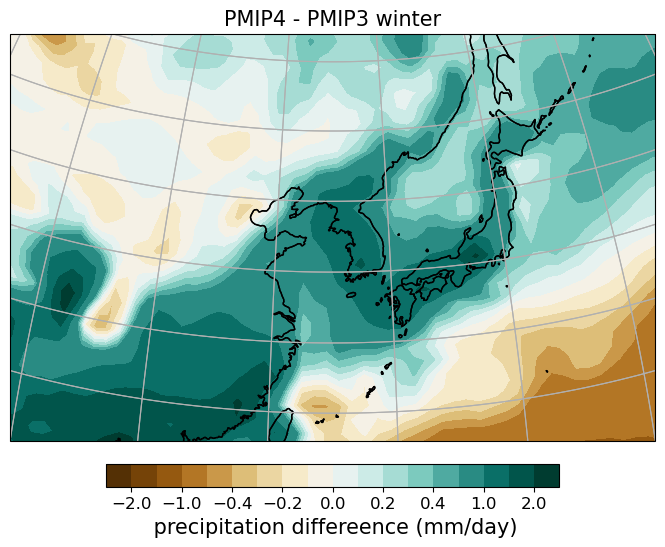

In [29]:
regional_plot_pr_diff('PMIP4 - PMIP3 winter',diff_pmip3)